In [148]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import os
from scipy import ndimage
import math

In [149]:
def apply_lowpass_filter(image, sigma=1.0):
    
    filtered_image = ndimage.gaussian_filter(image, sigma=sigma)
        
    return filtered_image

In [ ]:
def generate_fft_frequency_heatmap(image_path, nob=4, log_scale=True, sigma=1.0):

    # loading the image
    img = Image.open(image_path)
    
    # converting the image into grayscale
    img = img.convert('L')
    
    # converting the image into a numpy array
    img_array_original = np.array(img).astype(float)

    # applying a lowpass filter (sigma can change according to the desires of the user)
    img_array = apply_lowpass_filter(img_array_original, sigma=sigma)

    # showing the image with and without the lowpass filter applied (for comparison and validation)
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img_array_original, cmap='gray')
    axes[0].set_title('Original Image')
    axes[1].imshow(img_array, cmap='gray')
    axes[1].set_title('Lowpass Filter Applied')
    plt.tight_layout()
    plt.show()

    
    # getting the image dimensions
    height, width = img_array.shape
    
    # calculating the block size according to the number of blocks (nob) according to the input
    block_size = int(444 / (math.sqrt(nob)))
    num_blocks_y = height // block_size
    num_blocks_x = width // block_size
    
    # creating a heatmap with zeros
    heatmap = np.zeros((num_blocks_y, num_blocks_x))
    
    # going through the blocks and calculating the FFT
    for y in range(num_blocks_y):
        for x in range(num_blocks_x):
            # extracting the block
            block = img_array[y*block_size:(y+1)*block_size, 
                             x*block_size:(x+1)*block_size]
            
            # applying window function to reduce edge effects
            window = np.hanning(block_size)[:, np.newaxis] * np.hanning(block_size)
            windowed_block = block * window
            
            # applying 2D FFT
            fft_block = np.fft.fft2(windowed_block)
            
            # shifting zero frequency to center
            fft_shifted = np.fft.fftshift(fft_block)
            
            # calculating the magnitude spectrum
            magnitude_spectrum = np.abs(fft_shifted)
            
            # applying log scale if requested
            if log_scale:
                # adding a small constant to avoid log of zero
                magnitude_spectrum = np.log1p(magnitude_spectrum)
            
            # excluding the DC component (very low frequencies at the center)
            center = block_size // 2
            mask_size = 3  # size of the center mask
            mask = np.ones_like(magnitude_spectrum, dtype=bool)
            mask[center-mask_size:center+mask_size+1, center-mask_size:center+mask_size+1] = False
            
            # calculating the mean high-frequency component as our measure
            heatmap[y, x] = np.mean(magnitude_spectrum[mask])

    # extracing the diff between the max and min values of the heatmap
    heatmap_diff = np.max(heatmap) - np.min(heatmap)            
    
    # plotting the heatmap
    plt.figure(figsize=(10, 10))
    ax = sns.heatmap(heatmap, cmap='YlOrBr', cbar_kws={'label': 'Blocks Frequency Magnitude'})
    plt.title(f'FFT Frequency Heatmap (Block Size: {block_size}x{block_size})')
    plt.xlabel('X Blocks')
    plt.ylabel('Y Blocks')
    # adding the value of each block on top of the block
    for y in range(num_blocks_y):
        for x in range(num_blocks_x):
            plt.text(x+0.5, y+0.5, f'{round(heatmap[y, x], 4)}', fontsize=20, ha='center', va='center')
    print(f'minimum frequency value: {round(np.min(heatmap),4)}')
    print(f'max frequency value: {round(np.max(heatmap), 4)}')
    print(f'max frequency difference: {round(heatmap_diff, 4)}')
    plt.savefig('cloud_frequency_heatmap/fft_frequency_heatmap.png')
    plt.show()
    
    return heatmap

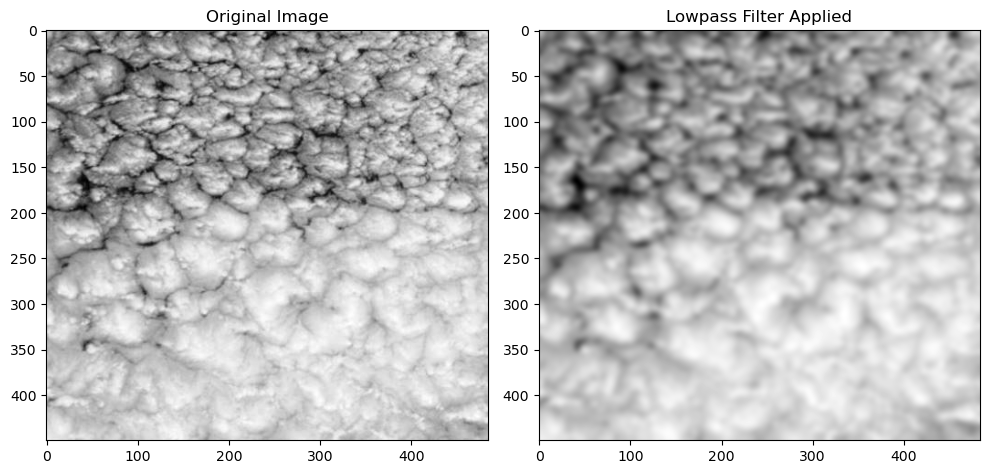

minimum frequency value: 0.4487
max frequency value: 0.6032
max frequency difference: 0.1545


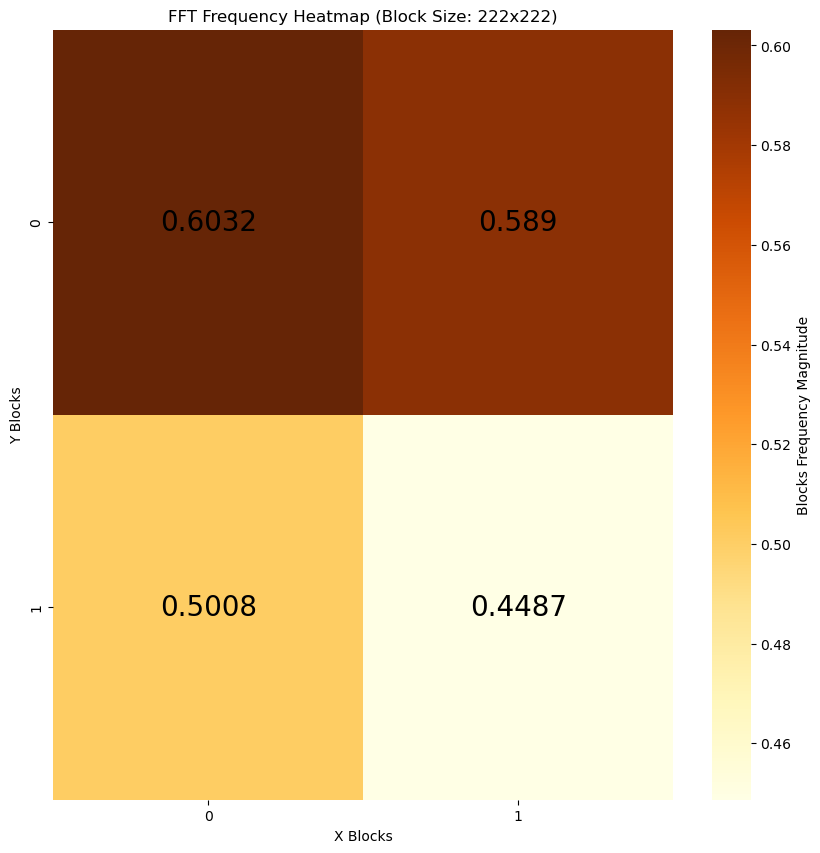

In [162]:
if __name__ == "__main__":

    nob = 4 # number of blocks (4, 9, 16, 25, 36, 49 ...)
    si = 3.0 # sigma
    nb = 4 # number of bands

    '''
    4 blocks = need to divide by 2 
    9 blocks = need to divide by 3
    16 blocks = need to divide by 4
    25 blocks = need to divide by 5
    36 blocks = need to divide by 6
    49 blocks = need to divide by 7
    '''

    if not os.path.exists('cloud_frequency_heatmap'):
        os.makedirs('cloud_frequency_heatmap')

    # image_path = "black_images_removed/20190803-18-17-87-86.jpeg"
    image_path = "black_images_removed/ttt.JPG"
    
    heatmap = generate_fft_frequency_heatmap(image_path, nob=nob, sigma=si)
    

